In [ ]:
from google.colab import files
uploaded = files.upload()

Saving topo.json to topo.json
Saving topo2.json to topo2.json
Saving topo3.json to topo3.json


In [ ]:
import numpy as np
import os
import sys
import json
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
def read_json_file(filename):
    with open(filename) as f:
        js_data = json.load(f)

        nodes = js_data['data']['mapTopology']['nodes']
        edges = js_data['data']['mapTopology']['edges']

        return(nodes, edges)


class network_env:
    def __init__(self, topo_file):

        self.nodes, self.edges = read_json_file(topo_file)
        self.edgesList = []
        self.Edgelist_gen()
        self.avail_util_paths = np.zeros([len(self.edgesList)])
        self.Path_utilization_gen()
        self.active_flows = []

    def step1(self, State, action, flow):


        flag = False
        for af in self.active_flows:

            af.counter -= 1
        if self.avail_util_paths[action] > flow.size:
            self.avail_util_paths[action] -= flow.size
            State.rec_flow_size.pop(0)
            State.rec_flow_dur.pop(0)
            State.rec_flow_action.pop(0)
            State.rec_flow_size.append(flow.size)
            State.rec_flow_dur.append(flow.dur)
            State.rec_flow_action.append(action)
            flow.allocated_to = action
            # print("flowsize", flow.size)
            # print("action", action)
            # print(flow.size)
            # print(flow.allocated_to)
            flow.counter += self.edgesList[action].lat
            # print(self.edgesList[action].lat)
            self.active_flows.append(flow)
            flag = True
        
        for af in self.active_flows:
        # print("allocatedto", self.active_flows[index].allocated_to)
        # print("activeflowsize", self.active_flows[index].size)
        
            if af.counter <= 0:
            
                self.active_flows.remove(af)
                # print('sss')
                # print(self.avail_util_paths[af.allocated_to])
                self.avail_util_paths[af.allocated_to] += af.size
                # print("allocated_to", af.allocated_to)
                # print(self.avail_util_paths[af.allocated_to])
                

        return flag, State
    def step2(self, State, flow):
        State.curr_flow = flow

        return State

    def reward(self):

        min_util = 1
        for index in range(len(self.edgesList)):
            # print('edgebw', self.edgesList[index].bw )
            # print("pathava", self.avail_util_paths[index])
            temp = (self.edgesList[index].bw - self.avail_util_paths[index]) / self.edgesList[index].bw
            if temp < min_util:
                min_util = temp
            return min_util
           
    def reset(self, k, curr_flow):
        rec_flow_size = []
        rec_flow_dur = []
        rec_flow_action = []

        for _ in range(k):
            EorM = random.randint(0, 9)
            # if between 2-9 mouse else elephant
            if (EorM > 1):
                rec_flow_size.append(random.randint(1, 2))
                rec_flow_dur.append(random.randint(1, 3))
                rec_flow_action.append(random.randint(0, len(self.edgesList)-1))
            else:
                rec_flow_size.append(random.randint(3, 5))
                rec_flow_dur.append(random.randint(10, 15))
                rec_flow_action.append(random.randint(0, len(self.edgesList) - 1))
                # print(rec_flow_size)
                # print(rec_flow_dur)
                # print(rec_flow_action)
        curr_state = GameState(rec_flow_size, rec_flow_dur, rec_flow_action, curr_flow)

        return curr_state
    def Edgelist_gen(self):
        i = 0
        for e in self.edges:
            edge_detail = Edge(i, i, e['BW'], e['Lat'], 'SRC', 'DST')
            i = i + 1
            self.edgesList.append(edge_detail)

   def Path_utilization_gen(self):

        for index in range(len(self.edgesList)):
            edge = self.edgesList[index]
            self.avail_util_paths[index] = edge.bw

def Generate_flow(Total_Flows, perc_ele): ##### Now the elephant rate is 20%
    all_flows = []
    # generate elephant or mice flow 100 flows
    for f in range(Total_Flows):
        EorM = random.uniform(0, 9)
        # if between 2-9 mouse else elephant
        if (EorM > 10 * perc_ele - 1):
            flowname = "mouse"
            flowsize = random.randint(1, 2)
            flowdur = random.randint(1, 3)
        else:
            flowname = "elephant"
            flowsize = random.randint(3, 5)
            flowdur = random.randint(10, 15)

            # print(flowname, flowsize, flowdur)
            # add active flows to queue
        flow_created = FlowTraffic(f, flowname, flowsize, flowdur)
        all_flows.append(flow_created)

    return all_flows


class GameState:
    def __init__(self, rec_flow_size, rec_flow_dur, rec_flow_action, curr_flow):
        self.rec_flow_size = rec_flow_size
        self.rec_flow_dur = rec_flow_dur
        self.rec_flow_action = rec_flow_action
        self.curr_flow = curr_flow

class Site(object):
    def __init__(self, num, siteID, name):



        self.num = num
        self.siteID = siteID
        self.name = name
            # print("New Site Node created with name:")
            # print(name)


class Edge(object):


    def __init__(self, num, edgeID, bw, lat, node1, node2):
        self.num = num
        self.edgeID = edgeID
        self.bw = bw
        self.lat = lat
        self.node1 = node1
        self.node2 = node2
        # print("New Edge created with id: %d" % edgeId)


class FlowTraffic(object):


    def __init__(self, num, name, size, dur):
        self.num = num
        self.name = name
        self.size = size
        self.dur = dur
        self.counter = dur
        self.allocated_to = None

In [ ]:
class Model(nn.Module):
    def __init__(self, input_shape, output_shape, hid_shape, hid_num, minibatch_size, activation='tanh'):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hid_shape = hid_shape
        self.hid_num = hid_num
        self.minibatch_size = minibatch_size
        if activation == 'tanh':
            self.activation = [nn.Tanh, torch.tanh]
        elif activation == 'relu':
            self.activation = [nn.ReLU, torch.relu]
        else:
            raise Exception('unsupported activation type')

        layers = [nn.Linear(self.input_shape, self.hid_shape), self.activation[0]()]
        for _ in range(self.hid_num):
            layers.extend([nn.Linear(self.hid_shape, self.hid_shape), self.activation[0]()])
        layers.append(nn.Linear(self.hid_shape, self.output_shape))
        self.model = nn.Sequential(*layers)

    def forward(self, x):

        return self.model(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
topology_file = ["topo.json", "topo2.json", "topo3.json"]


Episodes_Number = 50
K = 100
Max_Total_Flows = 5000
Min_Total_Flows = 3000
Input_shape = K * 3 + 3
Output_shape = 1
Hid_shape = 300
Hid_num = 6
Learning_rate = 1e-5
Minibatch_size = 50
Epochs = 20
Replay_size = 50000
Percent_of_elephant = [0.2, 0.25, 0.3]

def get_minibatch(samples, batch_size):
    State = []
    Reward = []
    for d in samples:
        state_list = []
        reward_list = []
        state = d[0]
        action = d[1]
        reward = d[2]
        state_list.extend(state.rec_flow_size)
        state_list.extend(state.rec_flow_dur)
        state_list.extend(state.rec_flow_action)
        state_list.append(state.curr_flow.size)
        state_list.append(state.curr_flow.dur)
        state_list.append(action)
        State.append(state_list)
        # print(reward)
        Reward.append([reward])
    # print(minibatch_state)
    State = torch.tensor(State).float()
    Reward = torch.tensor(Reward).float()
    train_data = torch.utils.data.TensorDataset(State, Reward)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)

    return train_loader




def training():

    criterion = nn.MSELoss()
    model = Model(Input_shape, Output_shape, Hid_shape, Hid_num, Minibatch_size)
    model.to(device)
    # task = random.randint(0, 2)
    replay_memory = []
    Loss = []
    task = 0
    env = network_env(topology_file[task])

    for episode in range(Episodes_Number):
        total_flows_num = random.randint(Min_Total_Flows, Max_Total_Flows)
        if episode == 20:
            task = 1
            env = network_env(topology_file[task])
            replay_memory = []
        if episode == 40:
            task = 2
            env = network_env(topology_file[task])
            replay_memory = []

        All_flows = Generate_flow(total_flows_num, Percent_of_elephant[0])
        curr_flow = All_flows[0]
        Curr_state = env.reset(K, curr_flow)
        iter = 0   
        while len(All_flows) > 1:
            action = random.randint(0, len(env.edgesList) -1)
            flag, Next_state = env.step1(Curr_state, action, curr_flow)
            if flag:
                All_flows.remove(curr_flow)
                curr_flow = All_flows[0]
                Next_state = env.step2(Next_state, curr_flow)
            # print('flag', flag)
            # print("Path availibity", env.avail_util_paths)
            Reward = env.reward()
            # print('reward', Reward)
            # save transition to replay memory
            replay_memory.append((Curr_state, action, Reward, Next_state))
            # if replay memory is full, remove the oldest transition
            if len(replay_memory) > Replay_size:
                replay_memory.pop(0)
        optimizer = torch.optim.SGD(model.parameters(), lr = Learning_rate)
        trainloader = get_minibatch(replay_memory, model.minibatch_size)
        # sample random minibatch
        running_loss = 0.0
        for epoch in range(Epochs):  # loop over the dataset multiple times
          
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                # if i % 2 == 0:    # print every 2000 mini-batches
            print("Episode", episode)
            print("Epoch", epoch)
            print("Loss", running_loss / i)
        Loss.append(running_loss / (Epochs * i))
        

# print(replay_memory)
    plt.figure(0)
    plt.plot(Loss)
    plt.ylabel('Trainning loss')
    plt.xlabel("Episodes")
    plt.grid(True)
    plt.title("Batch size = {}, Learning Rate = {}".format(Minibatch_size,Learning_rate))
    plt.show()

# Run agent functions

def test():
   print("test")



def main():
    training()
    test()





Episode 0
Epoch 0
Loss 0.15558813978927305
Episode 0
Epoch 1
Loss 0.3096363845497671
Episode 0
Epoch 2
Loss 0.4623088637987773
Episode 0
Epoch 3
Loss 0.6135962022976442
Episode 0
Epoch 4
Loss 0.7633792039270353
Episode 0
Epoch 5
Loss 0.9118626230593884
Episode 0
Epoch 6
Loss 1.059042934968014
Episode 0
Epoch 7
Loss 1.2049226635182746
Episode 0
Epoch 8
Loss 1.3491758429492362
Episode 0
Epoch 9
Loss 1.4923133942665476
Episode 0
Epoch 10
Loss 1.6341304377172932
Episode 0
Epoch 11
Loss 1.7747554422327967
Episode 0
Epoch 12
Loss 1.9139620879984864
Episode 0
Epoch 13
Loss 2.0520439199877507
Episode 0
Epoch 14
Loss 2.1887456775464194
Episode 0
Epoch 15
Loss 2.3242796418642757
Episode 0
Epoch 16
Loss 2.458652355303668
Episode 0
Epoch 17
Loss 2.591773704296411
Episode 0
Epoch 18
Loss 2.723935537868076
Episode 0
Epoch 19
Loss 2.854926564175673
Episode 1
Epoch 0
Loss 0.13754326617825277
Episode 1
Epoch 1
Loss 0.27301217049129844
Episode 1
Epoch 2
Loss 0.406350377582244
Episode 1
Epoch 3
Loss 0.53

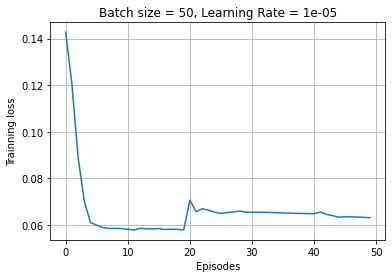

test


In [ ]:
main()